In [1]:
import sys
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

# import regressors
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression , RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
import pickle

from openbb import obb
sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
from utils import local_data_interface as ldi
from assets.api_credentials import openbb_pat
obb.account.login(pat=openbb_pat, remember_me=True)

from utils import local_data_interface as ldi
import indicators as inds
from indicators import pandas_ta_indicators as pti
from indicators import tulipy_indicators as ti
from indicators import metaindicators as mi
from indicators import custom_indicators as ci
from indicators import sets

from utils import ohlc_utils as ou

plt.rcParams['figure.figsize'] = [16, 4]

%load_ext autoreload
%autoreload 2

### Load data

In [2]:
#get raw ohlc data
symbols = sets.T001

ohlc_data = {}
for symbol in symbols:
    try:
        df = ldi.get_ticker(symbol=symbol, start_date="1980-01-01", end_date='2024-01-01', interval='1d')
        ohlc_data[symbol] = df
    except Exception as e:
        print(f"Error processing {symbol}: {e}")




In [3]:
# extract features
set = sets.perc_from_extrema
indicator_data = {}
for symbol in ohlc_data.keys():
    try:
        extractor = inds.Extractor(set) 
        ind_df = extractor.extract(df)
        
        #normalize each column of indicator data
        for c in ind_df.columns:
            if c != 'Date':
                ind_df[c] = (ind_df[c] - np.nanmean(ind_df[c])) / np.nanstd(ind_df[c])
        
        indicator_data[symbol] = ind_df
    except Exception as e:
        print(f"Error processing {symbol}: {e}")

In [4]:
# print nan % per column
for col in indicator_data['MSFT'].columns:
    nan_count = indicator_data['MSFT'][col].isna().sum()
    total_count = len(indicator_data['MSFT'][col])
    nan_percentage = (nan_count / total_count) * 100
    if nan_percentage > 0:
        print(f"{col}: {nan_percentage:.2f}% NaN values")


percent_from_local_high(period=2,key=close): 0.01% NaN values
percent_from_local_high(period=3,key=close): 0.02% NaN values
percent_from_local_high(period=5,key=close): 0.04% NaN values
percent_from_local_high(period=10,key=close): 0.08% NaN values
percent_from_local_high(period=14,key=close): 0.12% NaN values
percent_from_local_high(period=21,key=close): 0.18% NaN values
percent_from_local_high(period=30,key=close): 0.26% NaN values
percent_from_local_high(period=50,key=close): 0.44% NaN values
percent_from_local_high(period=100,key=close): 0.89% NaN values
percent_from_local_high(period=200,key=close): 1.79% NaN values
percent_from_local_high(period=330,key=close): 2.97% NaN values
percent_from_local_low(period=2,key=close): 0.01% NaN values
percent_from_local_low(period=3,key=close): 0.02% NaN values
percent_from_local_low(period=5,key=close): 0.04% NaN values
percent_from_local_low(period=10,key=close): 0.08% NaN values
percent_from_local_low(period=14,key=close): 0.12% NaN values


In [5]:
# create target variable that is the percent change between current close and the future 14 day mean
future_mean_window = 10 # days
target_data = {}
for symbol in ohlc_data.keys():
    try:
        ohlc_df = ohlc_data[symbol]
        target_df = pd.DataFrame(index=ohlc_df.index)
        target_df['target'] = ohlc_df['close'].rolling(window=future_mean_window).mean().shift(-future_mean_window) / ohlc_df['close'] - 1
        target_df['target'][target_df['target'] > 0] = 1
        target_df['target'][target_df['target'] <= 0] = 0
        
        target_data[symbol] = target_df
    except Exception as e:
        print(f"Error processing {symbol}: {e}")

C:\Users\avido\AppData\Local\Temp\ipykernel_58648\2132534747.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  target_df['target'][target_df['target'] > 0] = 1
C:\Users\avido\AppData\Local\Temp\ipykernel_58648\2132534747.py:10: FutureWarni

In [6]:
# Drop rows with NaN values in either DataFrame
for symbol in ohlc_data.keys():
    ind_df = indicator_data[symbol].dropna()
    target_df = target_data[symbol].dropna()

    # Align the indices of indicator_df and target_df
    ind_df = ind_df[ind_df.index.isin(target_df.index)]
    target_df = target_df[target_df.index.isin(ind_df.index)]

    indicator_data[symbol] = ind_df
    target_data[symbol] = target_df

In [7]:
train_test_split = .8

train_indicator_data = {}
train_target_data = {}
test_indicator_data = {}
test_target_data = {}
for symbol in ohlc_data.keys():
    try:
        ind_df = indicator_data[symbol]
        target_df = target_data[symbol]

        # Split the data into training and testing sets
        train_size = int(len(ind_df) * train_test_split)
        train_indicator_data[symbol] = ind_df.iloc[:train_size]
        train_target_data[symbol] = target_df.iloc[:train_size]
        test_indicator_data[symbol] = ind_df.iloc[train_size:]
        test_target_data[symbol] = target_df.iloc[train_size:]
    except Exception as e:
        print(f"Error processing {symbol}: {e}")


In [8]:
total_train_indicator_rows = 0
total_train_target_rows = 0
total_test_indicator_rows = 0
total_test_target_rows = 0
for symbol in ohlc_data.keys():
    total_train_indicator_rows += len(train_indicator_data[symbol])
    total_train_target_rows += len(train_target_data[symbol])
    total_test_indicator_rows += len(test_indicator_data[symbol])
    total_test_target_rows += len(test_target_data[symbol])

print(f"Total training indicator rows: {total_train_indicator_rows}")
print(f"Total training target rows: {total_train_target_rows}") 
print(f"Total testing indicator rows: {total_test_indicator_rows}")
print(f"Total testing target rows: {total_test_target_rows}")


Total training indicator rows: 109766
Total training target rows: 109766
Total testing indicator rows: 27448
Total testing target rows: 27448


In [9]:
#build master train/test dfs
train_indicator_df = pd.DataFrame()
train_target_df = pd.DataFrame()
test_indicator_df = pd.DataFrame()
test_target_df = pd.DataFrame()

for symbol in ohlc_data.keys():
    try:
        train_ind_df = train_indicator_data[symbol]
        train_targ_df = train_target_data[symbol]
        train_indicator_df = pd.concat([train_indicator_df, train_ind_df], ignore_index=True)
        train_target_df = pd.concat([train_target_df, train_targ_df], ignore_index=True)
        
        test_ind_df = test_indicator_data[symbol]
        test_targ_df = test_target_data[symbol]
        test_indicator_df = pd.concat([test_indicator_df, test_ind_df], ignore_index=True)
        test_target_df = pd.concat([test_target_df, test_targ_df], ignore_index=True)
    except Exception as e:
        print(f"Error processing {symbol}: {e}")

In [10]:
len(train_indicator_df), len(train_target_df)

(109766, 109766)

In [11]:
train_target_df.value_counts()

target
1.0       59581
0.0       50185
Name: count, dtype: int64

In [ ]:
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report




#naive calssifier is zero change
preds = np.ones(test_target_df.values.shape[0])
truths = test_target_df.values
acc = accuracy_score(truths, preds)
print("Naive Classifier:")
print("Accuracy:", acc)
print("Classification Report:")
print(classification_report(truths, preds, zero_division=0))
print()

models = [LogisticRegression(), RidgeClassifier(), KNeighborsClassifier(), 
          DecisionTreeClassifier(), RandomForestClassifier(),
          XGBClassifier(),
        #   SVC()
        ]

for model in models:
    now = datetime.now()
    model.fit(train_indicator_df.values, train_target_df.values)
    preds = model.predict(test_indicator_df.values)
    acc = accuracy_score(truths, preds)
    print("Model:", model.__class__.__name__)
    print("Accuracy:", acc)
    
    corr = (np.corrcoef(preds, truths.flatten())[0, 1] + 1) / 2
    print("Correlation:", corr)
    print("Elapsed time:", datetime.now() - now)
    print()


Naive Classifier:
Accuracy: 0.5634654619644418
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     11982
         1.0       0.56      1.00      0.72     15466

    accuracy                           0.56     27448
   macro avg       0.28      0.50      0.36     27448
weighted avg       0.32      0.56      0.41     27448




c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: LogisticRegression
Accuracy: 0.5401850772369572
Correlation: 0.495407625847121
Elapsed time: 0:00:00.238299

Model: RidgeClassifier
Accuracy: 0.5402215097639173
Correlation: 0.49521814635870154
Elapsed time: 0:00:00.075661



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\linear_model\_ridge.py:1307: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model: KNeighborsClassifier
Accuracy: 0.5725735937044594
Correlation: 0.564900325029074
Elapsed time: 0:00:03.785767

Model: DecisionTreeClassifier
Accuracy: 0.5476901777907316
Correlation: 0.5472023973702448
Elapsed time: 0:00:01.658917



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model: RandomForestClassifier
Accuracy: 0.5686024482658117
Correlation: 0.5570466742140809
Elapsed time: 0:00:29.255121

Model: XGBClassifier
Accuracy: 0.561461672981638
Correlation: 0.5512403691344251
Elapsed time: 0:00:00.653381



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


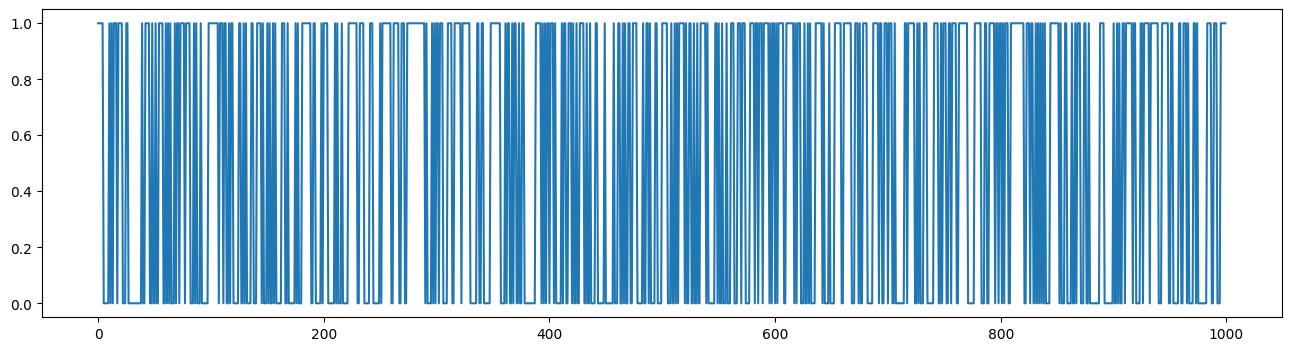

In [12]:
model = KNeighborsClassifier()
model.fit(train_indicator_df.values, train_target_df.values)
preds = model.predict(test_indicator_df.values[-1000:])

# plt.plot(preds, label='Predictions')
# plt.plot(test_target_df.values[-1000:], label='True Values', alpha=0.5)
plt.plot(preds.flatten() == test_target_df.values[-1000:].flatten(), label='Correct Predictions')

In [22]:
model = LinearRegression()
model.fit(train_indicator_df.values, train_target_df.values)
preds = model.predict(train_indicator_df.values)

plt.plot(preds[-1000:], label='Predictions')
plt.plot(train_target_df.values[-1000:], label='True Values', alpha=0.5)

corr_coef = np.corrcoef(preds.flatten(), train_target_df.values.flatten())[0, 1]
print("Correlation Coefficient:", corr_coef)

NameError: name 'LinearRegression' is not defined

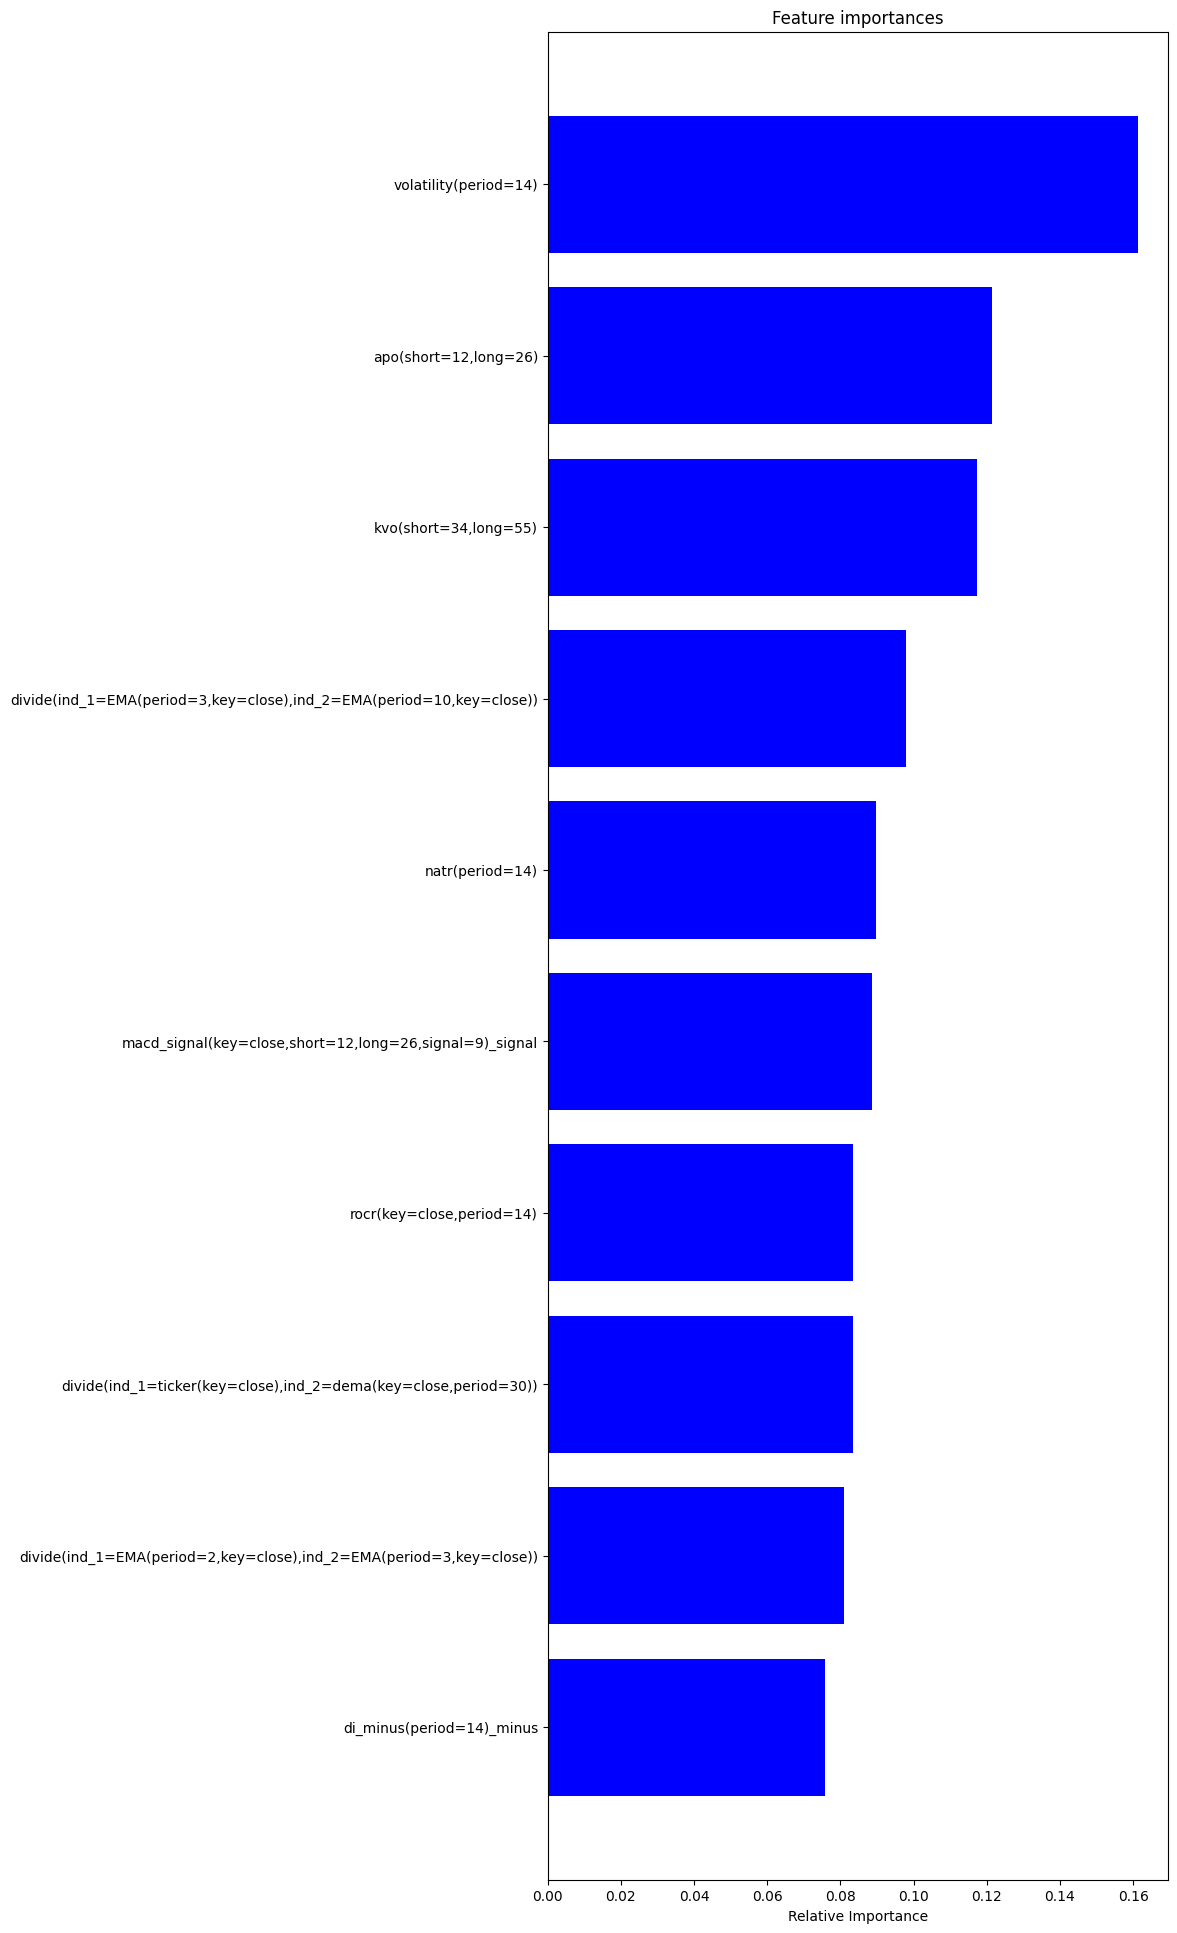

In [ ]:
# see which features are most important in RandomForestRegressor(
cols = train_indicator_df.columns
order = np.argsort(model.feature_importances_)
importances = model.feature_importances_[order]
indices = np.arange(len(importances))
plt.figure(figsize=(8, 24))
plt.title("Feature importances")
plt.barh(indices, importances, color="b", align="center")
plt.yticks(indices, cols[order])
plt.xlabel("Relative Importance")
plt.show()



In [ ]:
def segment_with_overlap(data, seg_s=None, seg_n: int = None, overlap_s: float = None, overlap_n: int = None, fs: int = None):
    """
    Returns a view into data of shape [num_channels, num_seg, num_samples] with ability to overlap

    Input
    ------
    data: np.array
        Data of shape [num_channels, num_samples]. Must be 2d (for vectors, use np.reshape(1, -1))
    seg_s/seg_n: float
        Length of segments in seconds/samples
    overlap_s/overlap_n: float
        Amount of overlap in seconds/samples.
    fs: int
        Sampling frequency

    Returns
    -------
    segments : np.array
        Segmented data of shape [num_channels, num_seg, num_samples]
    """
    if  len(data.shape) != 2:
        raise ValueError("Data must be 2d. try adding a dimension with np.reshape(1, -1)")
    assert ((seg_s is not None) and (fs is not None)) or (
                seg_n is not None), "Must specify either seg_s and fs or seg_n"
    assert ((overlap_s is not None) and (fs is not None)) or (
                overlap_n is not None), "Must specify either overlap_s and fs or overlap_n"
    if seg_s is not None:
        seg_n = int(seg_s * fs)
    if overlap_s is not None:
        overlap_n = int(overlap_s * fs)
    stride = seg_n - overlap_n  # step size between segments
    n_seg = (data.shape[-1] - seg_n) // stride + 1  # number of segments
    shape = (data.shape[0], int(n_seg), seg_n)  # output shape
    element_size = data.strides[-1]  # size of each data element in bytes
    strides = (data.strides[0], stride * element_size, element_size)
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

In [ ]:
lag_dim = 3

#Now try with lagged features lagged feature array
#create lagged values
x_train_lagged = segment_with_overlap(train_indicator_df.values.T, seg_n = lag_dim, overlap_n = lag_dim-1)
x_train_lagged = x_train_lagged.swapaxes(0,1)
x_train_lagged = x_train_lagged.reshape(x_train_lagged.shape[0], -1)
y_train_lagged = train_target_df.values[-len(x_train_lagged):]

x_test_lagged = segment_with_overlap(test_indicator_df.values.T, seg_n = lag_dim, overlap_n = lag_dim-1)
x_test_lagged = x_test_lagged.swapaxes(0,1)
x_test_lagged = x_test_lagged.reshape(x_test_lagged.shape[0], -1)
y_test_lagged = test_target_df.values[-len(x_test_lagged):]

#linear regression
lr = LinearRegression()
now = datetime.now()
lr.fit(x_train_lagged, y_train_lagged)
preds = lr.predict(x_test_lagged)
mse = np.mean((preds - y_test_lagged)**2)
print("Lagged Linear Regression:", mse)
print("Elapsed time:", datetime.now() - now)
print()

#ridge regression
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], store_cv_values=True)
now = datetime.now()
ridge.fit(x_train_lagged, y_train_lagged)
preds = ridge.predict(x_test_lagged)
mse = np.mean((preds - y_test_lagged)**2)
print("Lagged Ridge Regression:", mse)
print("Elapsed time:", datetime.now() - now)
print()

#lasso
lasso = LassoCV(alphas=[0.1, 1.0, 10.0], cv=5)
now = datetime.now()
lasso.fit(x_train_lagged, y_train_lagged)
preds = lasso.predict(x_test_lagged)
mse = np.mean((preds - y_test_lagged)**2)
print("Lagged Lasso Regression:", mse)
print("Elapsed time:", datetime.now() - now)
print()

dtr = DecisionTreeRegressor()
now = datetime.now()
dtr.fit(x_train_lagged, y_train_lagged)
preds = dtr.predict(x_test_lagged)
mse = np.mean((preds - y_test_lagged)**2)
print("Lagged Decision Tree Regression:", mse)
print("Elapsed time:", datetime.now() - now)
print()

#random forest
rfr = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
now = datetime.now()
rfr.fit(x_train_lagged, y_train_lagged)
preds = rfr.predict(x_test_lagged)
mse = np.mean((preds - y_test_lagged)**2)
print("Lagged Random Forest Regressor:", mse)
print("Elapsed time:", datetime.now() - now)
print()

#svr
svr = SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=.1)
now = datetime.now()
svr.fit(x_train_lagged, y_train_lagged)
preds = svr.predict(x_test_lagged)
mse = np.mean((preds - y_test_lagged)**2)
print("Lagged SVR:", mse)
print("Elapsed time:", datetime.now() - now)
print()

Lagged Linear Regression: 0.8947769254636311
Elapsed time: 0:00:00.090343



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Lagged Ridge Regression: 0.8876625061061743
Elapsed time: 0:00:05.354338



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lagged Lasso Regression: 0.8776186068564821
Elapsed time: 0:00:05.771352

Lagged Decision Tree Regression: 1.3162718751016909
Elapsed time: 0:00:10.213682



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Lagged Random Forest Regressor: 0.9097701276039224
Elapsed time: 0:02:25.561340



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
